# Sampling from a bimodal normal distribution using Sequential Monte Carlo

This example shows how Sequential Monte Carlo can be used to sample from a bimodal normal distribution. If the object passed to Pints is not of type log_posterior - as here where a log_pdf is passed instead - then we assume independent uniform priors between -100 and 100, for each dimension.

In Sequential Monte Carlo, a series of tempered distributions are sampled from, whose density has the form,

$\beta \; \text{log} \; p(\theta|x) + (1-\beta) \; \text{log} \; p(\theta)$,

where $p(\theta|x)$ is the posterior and $p(\theta)$ is the prior, and $\beta\in(0,1]$ is a (inverse-)temperature parameter. By default, Pints uses a series of temperatures which are uniform on the log scale. Note that, when $\beta=1$, the density of the tempered distribution matches the posterior.

Show the distribution we aim to sample from.

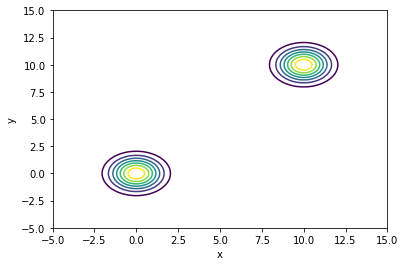

In [1]:
import os
os.chdir('../')
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.MultimodalNormalLogPDF()

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Sampling
Setup the sampler and run it.

In [26]:
# Select mean and variance matrix of initial proposal dist
x0 = [5, 5]
sigma0 = [[2, 0], [0, 2]]

# Create mcmc routine
sampler = pints.SMC(log_pdf, x0, sigma0)

# Set number of temperatures (uniform on log scale)
sampler.set_temperature_schedule(10)

# Set number of particles
sampler.set_particles(5000)

# Set number of MCMC steps at each temperature
sampler.set_kernel_samples(3)

# Run sampler
samples = sampler.run()

Running Sequential Monte Carlo
Total number of particles: 5000
Number of temperatures: 10
Resampling at end of each iteration
Number of MCMC steps at each temperature: 3
Temperature Eval. Time m:s
 0.99972    21000   0:08.0
 0.99923    36000   0:16.0
 0.99785    51000   0:24.0
 0.99401    66000   0:32.0
 0.98332    81000   0:40.0
 0.95358    96000   0:48.1
 0.87085    111000   0:56.0
 0.64062    126000   1:04.1
 0          141000   1:12.1


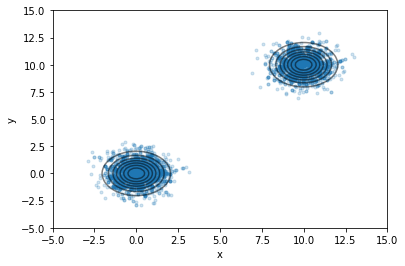

In [27]:
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(samples[:,0], samples[:,1], marker='.', alpha=0.2)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Post estimation

Look at distribution of weights on final particles.

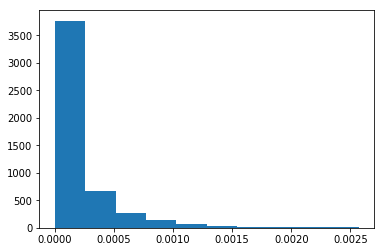

In [4]:
weights = sampler.weights()
plt.hist(weights)
plt.show()

Print the effective sample size based on the formula,

$ess = \frac{1}{\sum_{i=1}^k w_i^2},$

where $w_i$ is the weight of particule $i$.

In [5]:
print('ess = ', sampler.ess())

ess =  1491.62988947


In [6]:
np.log(0.8)

-0.22314355131420971

In [7]:
mcmc = pints.AdaptiveCovarianceMCMC(x0, sigma0)

In [8]:
mcmc._current = [5, 5]

In [9]:
weights = np.copy(sampler.weights())
print(weights)

[  6.89765337e-05   9.29792025e-06   3.96625579e-06 ...,   9.33716349e-04
   8.34892221e-04   2.15591780e-04]


In [10]:
sampler._weights = np.copy(weights)
print(sampler._weights)
samples_log_pdf_old = np.copy(sampler._samples_log_pdf_old)
samples_old = np.copy(sampler._samples_old)
samples_new = np.copy(sampler._samples)
_log_posterior = sampler._log_posterior
_log_prior = sampler._log_prior
sampler._new_weights(0.8, 1.0)
print(sampler._weights)

[  6.89765337e-05   9.29792025e-06   3.96625579e-06 ...,   9.33716349e-04
   8.34892221e-04   2.15591780e-04]
[  6.50968385e-05   8.77494388e-06   3.74316741e-06 ...,   7.89459616e-04
   6.68332283e-04   1.33134268e-04]


In [11]:
from scipy.special import logsumexp
def _w_tilde(x_old, x_new, beta_old, beta_new):
    """
    Calculates the log unnormalised incremental weight as per eq. (31) in
    Del Moral.
    """
    return _tempered_distribution(x_old, beta_new) - _tempered_distribution(x_old, beta_old)

def _new_weight(w_old, x_old, x_new, beta_old, beta_new):
    """
    Calculates the log new weights as per algorithm 3.1.1. in Del Moral et
    al. (2006).
    """
    w_tilde_value = _w_tilde(x_old, x_new, beta_old, beta_new)
    return w_old + w_tilde_value

def _new_weights(w_old, samples_old, samples_new, beta_old, beta_new):
    """
    Calculates the new weights as per algorithm 3.1.1 in Del Moral et al.
    (2006).
    """
    w_new = np.array([
          _new_weight(
              w, samples_old[i], samples_new[i], beta_old, beta_new)
          for i, w in enumerate(w_old)])

    return w_new
def _tempered_distribution(x, beta):
    """
    Returns the tempered log-pdf:
    ``beta * log pi(x) + (1 - beta) * log prior(x)``
    If not explicitly given prior is assumed to be multivariate normal.
    """
    return beta * _log_posterior(x) + (1 - beta) * _log_prior(x)

In [12]:
_w_tilde(samples_old[0], samples_new[0], 0.8, 1)

1.5351643269363624

In [13]:
sampler._w_tilde(samples_log_pdf_old[0], _log_prior(samples_old[0]), 0.8, 1)

1.5351643269363615

In [14]:
w1 = _new_weights(weights, samples_old, samples_new, 0.8, 1)

In [15]:
_new_weight(weights[0], samples_old[0], samples_new[0], 0.8, 1.0)

1.5352333034700365

In [16]:
sampler._new_weight(weights[0], samples_log_pdf_old[0], _log_prior(samples_old[0]), 0.8, 1)

-8.0465798759542508

In [17]:
weights_temp = np.zeros(len(weights))
for i, w in enumerate(weights):
    fx_old = samples_log_pdf_old[i]
    f_prior_old = _log_prior(samples_old[i])
    weights_temp[i] = sampler._new_weight(w, fx_old,
                                                f_prior_old,
                                                0.8, 1)
print(len(weights_temp))

5000


In [18]:
diff = w1 - weights_temp

In [19]:
diff[0:100]

array([  9.58181318,  11.58572911,  12.437692  ,  14.13307365,
        10.41125472,  11.99821178,  11.82227366,  11.28213751,
        12.12914452,   9.50579628,   8.61308216,   8.72297119,
         7.92070246,   9.18884532,  11.71757371,   8.58401766,
        10.99943275,   8.58868785,   7.20312281,   6.47601735,
         8.58729258,   9.54309671,   7.59823243,   6.69528824,
         6.62495328,   7.95877604,   8.04548236,   6.03946658,
         7.75744935,   6.87268509,   6.4097    ,   7.25842435,
         8.92815577,   7.89851666,  15.1516725 ,  14.42839396,
         9.99527348,   9.84032035,  13.68452065,  12.41582154,
        10.20592856,   9.73818721,   9.85450184,   9.4733426 ,
         9.76299125,   7.11036074,   7.63726376,   8.52045424,
         7.21393217,   7.21172089,  10.13745674,   7.48985756,
        10.55521978,   6.71139058,  10.75417689,  10.35692267,
         7.16840263,   6.44612557,   8.01741152,   9.1998122 ,
         9.47833508,  10.76389097,  11.23903096,  14.48

In [20]:
_w_tilde(samples_old[3], samples_new[3], 0.8, 1)

1.7410988656029234

In [21]:
sampler._w_tilde(samples_log_pdf_old[3], _log_prior(samples_old[3]), 0.8, 1)

1.7410988656029234

In [22]:
_log_posterior(samples_old[3])

-1.8911404050814558

In [23]:
samples_log_pdf_old[3]

-1.8911404050814558

In [24]:
samples_old[3]

array([  9.7306649 ,  10.18435097])

In [25]:
for i in range(0, 5):
    print(i)

0
1
2
3
4
